In [77]:
import os
import pandas as pd
import os.path as op
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms

# Load data in 2019

In [78]:
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96} 
images = np.memmap("./20d_month_has_vb_[20]_ma_2019_images.dat", dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
plt.imshow(images[0], cmap='gray')
plt.show()
print(len(images))

1502123


# Class for extracting activations and registering gradients from targeted intermediate layers

In [79]:
class ActivationsAndGradients:

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:  # forward_hook for every target_layer
            self.handles.append(
                target_layer.register_forward_hook(  
                    self.save_activation))
            # Backward compatibility with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):  # if the version of pytorch is new
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):  # collect outputs
        activation = output
        self.activations.append(activation.cpu().detach())  # put in the memory, detach gradients, save in the end of the list

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        self.gradients = [grad.cpu().detach()] + self.gradients  # save in the begining of the list

    def __call__(self, x):  # forward pass
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

# Implement Grad-CAM class

The main idea of Gradient-weighted Class Activation Mapping (Grad-CAM) is using the gradient information flowing into particular layer to understand the importance of each neuron.

$$
L^c_{\text{Grad-CAM}} = ReLU\left(\sum_k\alpha_k^cA^k\right),\quad
\alpha_k^c = \frac{1}{Z}\sum_i\sum_j\frac{\partial y^c}{\partial A^k_{ij}},
$$

where $y^c$ is the score of class $c$, $A^k$ is the $k$-th feature map, $Z$ is the size of the $k$-th feature map. Note that $\alpha_k^c$ represents the ‘importance’ of feature map $k$ for a target class $c$. The final Grad-CAM $L^c_{\text{Grad-CAM}}$ is the ReLU of weighted combination of forward activation maps.

$L^c_{\text{Grad-CAM}}$ is computed in the function ''compute_cam_per_layer''. The function ''get_cam_weights'', ''get_loss'', ''get_cam_image'' compute $\alpha_k^c$, $y^c$ and weighted sum respectively.

In [80]:
class GradCAM:
    def __init__(self,
                 model,
                 target_layers,
                 reshape_transform=None,
                 use_cuda=False):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.cuda = use_cuda  # if use GPU
        if self.cuda:
            self.model = model.cuda()
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    @staticmethod
    def get_cam_weights(grads):  # alpha^k
        return np.mean(grads, axis=(2, 3), keepdims=True)

    @staticmethod
    def get_loss(output, target_category):  # y^c
        loss = 0
        for i in range(len(target_category)):
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self, activations, grads):  # weighted sum
        weights = self.get_cam_weights(grads)
        weighted_activations = weights * activations
        cam = weighted_activations.sum(axis=1)

        return cam

    @staticmethod
    def get_target_width_height(input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(self, input_tensor):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor) # size of the original image

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for layer_activations, layer_grads in zip(activations_list, grads_list):
            cam = self.get_cam_image(layer_activations, layer_grads)
            cam[cam < 0] = 0  # ReLU
            scaled = self.scale_cam_image(cam, target_size)  # min-max scale, resize
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result)

    @staticmethod
    def scale_cam_image(cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img) # scale to (0,1)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:  # resize to the size of the original image
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)

        return result

    def __call__(self, input_tensor, target_category=None):

        if self.cuda:  # if use GPU
            input_tensor = input_tensor.cuda()

        output = self.activations_and_grads(input_tensor)
        if isinstance(target_category, int):  # if target_category is int
            target_category = [target_category] * input_tensor.size(0)  # change to list with length is number of images in this batch

        if target_category is None:  # argmax of the output
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
            print(f"category id: {target_category}")
        else:
            assert (len(target_category) == input_tensor.size(0))

        self.model.zero_grad()  
        loss = self.get_loss(output, target_category)   # yc
        loss.backward(retain_graph=True) # activate hook function

        cam_per_layer = self.compute_cam_per_layer(input_tensor)  # get L_grad-cam
        return self.aggregate_multi_layers(cam_per_layer)  # no influence if only see one layer

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

# Define our CNN architechture

In [81]:
import torch.nn as nn
class CNN(nn.Module):

    def __init__(self, 
                 num_class=2,       
                 initial_filter = 64,
                 filter_sizes= (5,3),
                 maxpool_sizes= (2,1),
                 dilation=(2,1),
                 stride=(2,1),
                 p=0.5,
                 BN=True,
                 Activation='LRELU'
                ):
        
        super(CNN, self).__init__()
        
        padding = (
            (filter_sizes[0]-1)//2,
            (filter_sizes[1]-1)//2
       )
        
        #BOOLEAN:whether to use batch norm
        self.BN = BN
        #STRING: type of activation
        self.Activation = Activation
        # int : 2 for binary
        self.num_class = num_class
        # float: prob for dropout
        self.p = p
        
        if self.Activation=='LRELU':
            self.lrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        else:
            self.lrelu = nn.ReLU(inplace=True)
            
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                      out_channels=initial_filter, 
                      kernel_size=filter_sizes,
                      padding=padding,
                      stride=stride, 
                      dilation=dilation)
        
        self.bn1 = nn.BatchNorm2d(initial_filter)
        self.pool1 = nn.MaxPool2d(kernel_size=maxpool_sizes, 
                                       stride=maxpool_sizes)
            
            
        self.conv2= nn.Conv2d(
                      in_channels=initial_filter, 
                      out_channels=initial_filter*2, 
                      kernel_size=filter_sizes,
                      padding=padding
                      )
        
        self.bn2 = nn.BatchNorm2d(initial_filter*2)
        self.pool2 = nn.MaxPool2d(kernel_size=maxpool_sizes, 
                                  stride=maxpool_sizes)
            
        self.conv3 = nn.Conv2d(in_channels=initial_filter*2, 
                      out_channels=initial_filter*4, 
                      kernel_size=filter_sizes,
                      padding=padding
                      )
                        
        self.bn3=nn.BatchNorm2d(initial_filter*4)
        self.pool3 = nn.MaxPool2d(kernel_size=maxpool_sizes, 
                                  stride=maxpool_sizes)
        
        
        #no need for softmax
        #self.classifier = nn.Softmax(dim=1) #dim=1        
        
        self.fc = nn.Linear(46080, self.num_class)
        
        self.dropout = nn.Dropout(p=self.p)
        
        #XAVIER initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    
    def forward(self, x):
        #print('Block1')
        x = self.conv1(x)
        #print(x.shape)
        if self.BN:
            x = self.bn1(x)
        x = self.lrelu(x)
        x = self.pool1(x)
        #print(x.shape)

        #print('Block2')
        x = self.conv2(x)
        #print(x.shape)
        if self.BN:
            x = self.bn2(x)
        x = self.lrelu(x)
        x = self.pool2(x)
        #print(x.shape)
        
        #print('Block3')
        x = self.conv3(x)
        #print(x.shape)
        if self.BN:
            x = self.bn3(x)
        x = self.lrelu(x)
        x = self.pool3(x)
        #print(x.shape)
        
        
        
        x = x.view(x.size(0), -1)
        #print('Flatten-FC')
        #print(x.shape)
        
        x = self.dropout(x)
        #drop out applied to Linear layer. 
        #print('after drop out')
        #print(x.shape)
        x = self.fc(x)
        #x=self.dropout(self.fc(x))        
        
        #softmax is not needed for our loss function
        #print('after linear layer')
        #print(x.shape)
        #x = self.classifier(x)  #take a vector z [2,1] -> probability [2,1]

        return x
from torchsummary import summary
model = CNN()
print(model)

CNN(
  (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv1): Conv2d(1, 64, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1), dilation=(2, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=46080, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Randomly draw positive and negative samples classified by seed 0 CNN

In [82]:
import random
random.seed(50)
po = []
ne = []

model = torch.load('./Baseline_GPU_0_final.t7', map_location=torch.device('cpu'))['net']
target_layers = [model.conv3]
while len(po) < 10 or len(ne) < 10:
    j = random.randint(1,len(images))
    # load test image
    img = torch.from_numpy(images[j]).type(torch.float)  # 64*60
    img = np.array(img, dtype=np.uint8)  # some transformations

    data_transform = transforms.Compose([transforms.ToTensor()]) # to [0,1]
    img_tensor = data_transform(img)
    input_tensor = torch.unsqueeze(img_tensor, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    output = cam.activations_and_grads(input_tensor)
    target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
    
    if target_category == 1 and len(po) < 10: po.append(j)
    elif target_category == 0 and len(ne) < 10 and images[j].max() > 0: ne.append(j)

# Get figures of Grad-CAM

<IPython.core.display.Javascript object>


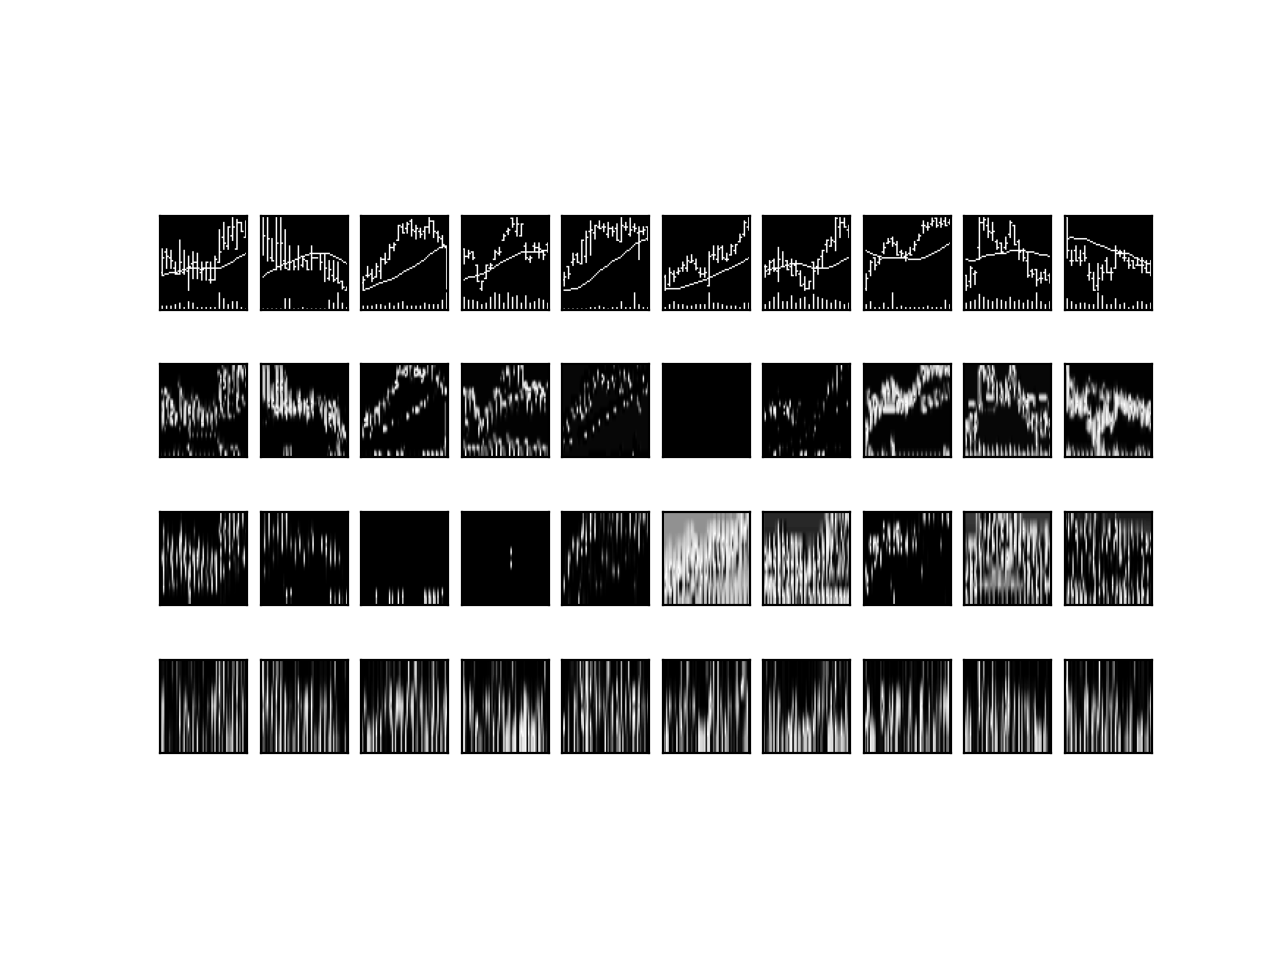

In [83]:
# grad-cam figures for positive return samples 
%matplotlib notebook
for i in range(4):
    for j in range(10):
        if i == 0:     # the first row: original images
            plt.subplot(4, 10, i*10+j+1)
            plt.gca().axes.xaxis.set_visible(False)
            plt.gca().axes.yaxis.set_visible(False)
            plt.imshow(images[po[j]], cmap='gray')
        else:
            model = torch.load('./Baseline_GPU_0_final.t7', map_location=torch.device('cpu'))['net']
            target_layers = [eval("model.pool"+str(i))]

            # load test image
            img = torch.from_numpy(images[po[j]]).type(torch.float)  # 64*60
            img = np.array(img, dtype=np.uint8)

            data_transform = transforms.Compose([transforms.ToTensor()]) # to [0,1]
            img_tensor = data_transform(img)
            input_tensor = torch.unsqueeze(img_tensor, dim=0)  # expand batch dimension

            cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
            target_category = 1  # positive return

            grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

            grayscale_cam = grayscale_cam[0, :]  # the first image of grad-cam
            grayscale_cam = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)  # brighter
            grayscale_cam = cv2.cvtColor(grayscale_cam, cv2.COLOR_BGR2GRAY)

            plt.subplot(4, 10, i*10+j+1)
            plt.gca().axes.xaxis.set_visible(False)
            plt.gca().axes.yaxis.set_visible(False)
            plt.imshow(grayscale_cam, cmap = 'gray')

plt.subplots_adjust(wspace=0.15,hspace=-0.5)
plt.show()

<IPython.core.display.Javascript object>


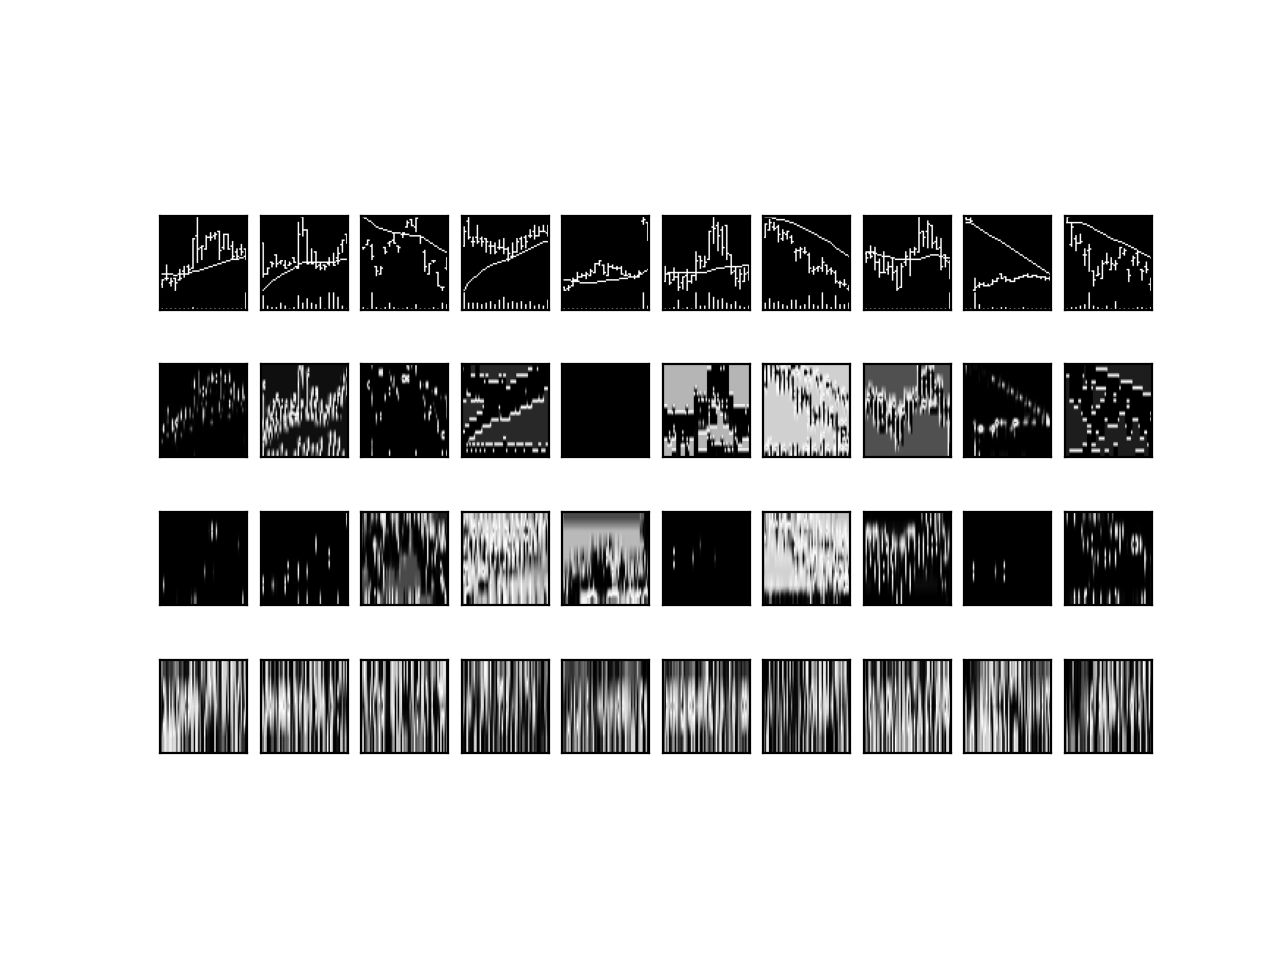

In [84]:
# grad-cam figures for negative return samples 
%matplotlib notebook
for i in range(4):
    for j in range(10):
        if i == 0:    # the first row: original images
            plt.subplot(4, 10, i*10+j+1)
            plt.gca().axes.xaxis.set_visible(False)
            plt.gca().axes.yaxis.set_visible(False)
            plt.imshow(images[ne[j]], cmap='gray')
        else:
            model = torch.load('./Baseline_GPU_0_final.t7', map_location=torch.device('cpu'))['net']
            target_layers = [eval("model.pool"+str(i))]

            # load test image
            img = torch.from_numpy(images[ne[j]]).type(torch.float)  # 64*60
            img = np.array(img, dtype=np.uint8)  

            data_transform = transforms.Compose([transforms.ToTensor()]) # to [0,1]
            img_tensor = data_transform(img)
            input_tensor = torch.unsqueeze(img_tensor, dim=0) # expand batch dimension

            cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
            target_category = 0  # negative return

            grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

            grayscale_cam = grayscale_cam[0, :]  # the first image of grad-cam
            grayscale_cam = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)  # brighter
            grayscale_cam = cv2.cvtColor(grayscale_cam, cv2.COLOR_BGR2GRAY)

            plt.subplot(4, 10, i*10+j+1)
            plt.gca().axes.xaxis.set_visible(False)
            plt.gca().axes.yaxis.set_visible(False)
            plt.imshow(grayscale_cam, cmap = 'gray')
plt.subplots_adjust(wspace=0.15,hspace=-0.5)
plt.show()